In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset.dataloader import CINE2DT
from utils import compressed_sensing as cs,dict2obj,multicoil2single
from utils.dnn_io import to_tensor_format, from_tensor_format
from torch.autograd import Variable
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # 指定使用 GPU 1 和 GPU 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [17]:
# 辅助函数：将多线圈数据转换为单线圈数据
# def multicoil2single(kspace, coilmaps):
#     ref_kspace = torch.sum(kspace * coilmaps.conj(), dim=1, keepdim=True)
#     ref_img = torch.fft.ifft2(ref_kspace, dim=(-2, -1))
#     return ref_kspace, ref_img

# 辅助函数：准备输入数据（欠采样）
# def prep_input(im, acc=4.0):
#     batch_size, time, height, width = im.shape
#     mask = get_cine_mask(int(acc), x=time, y=height)
#     mask = np.expand_dims(mask, axis=0)
#     mask = np.expand_dims(mask, axis=0)
#     mask = np.tile(mask, (batch_size, width, 1, 1))
#     mask_tensor = torch.from_numpy(mask)
#     mask_permuted = mask_tensor.permute(0, 3, 2, 1)
#     mask_l = torch.from_numpy(to_tensor_format(mask, mask=True))
#     mask_l = mask_l.permute(0, 1, 2, 4, 3)
#     im_np = im.numpy() if isinstance(im, torch.Tensor) else im
#     mask_np = mask_permuted.numpy() if isinstance(mask_permuted, torch.Tensor) else mask_permuted
#     im_und, k_und = cs.undersample(im_np, mask_np, centred=False, norm='ortho')
#     im_gnd_l = torch.from_numpy(to_tensor_format(im))
#     im_und_l = torch.from_numpy(to_tensor_format(im_und))
#     k_und_l = torch.from_numpy(to_tensor_format(k_und))
#     return im_und_l, k_und_l, mask_l, im_gnd_l
# def prep_input(im, acc_rate_value):
#     # 获取输入图像的形状
#     batch_size, time, height, width = im.shape
#     print('prep-input:', im.shape)

#     # 生成欠采样掩码
#     mask = get_cine_mask(int(acc_rate_value), x=time, y=height)  # 使用 get_cine_mask 生成掩码
#     mask = np.expand_dims(mask, axis=0)  # 添加 batch 维度
#     mask = np.expand_dims(mask, axis=0)  # 添加 channel 维度
#     mask = np.tile(mask, (batch_size, width, 1, 1))  # 调整形状以匹配输入图像

#     # 调整掩码的维度顺序以匹配输入图像
#     mask = np.transpose(mask, (0, 3, 2, 1))  # 将 (1, 192, 192, 18) 调整为 (1, 18, 192, 192)
#     print('mask:', mask.shape)

#     # 将掩码转换为 PyTorch 张量
#     mask_tensor = torch.from_numpy(mask).float()

#     # 将输入张量移动到 CPU（如果它在 GPU 上）
#     if im.device != torch.device('cpu'):
#         im = im.cpu()

#     # 转换为 NumPy 数组
#     im_np = im.numpy()
#     mask_np = mask_tensor.numpy()

#     # 打印形状以调试
#     print(f"im_np shape: {im_np.shape}")
#     print(f"mask_np shape: {mask_np.shape}")

#     # 欠采样
#     im_und, k_und = cs.undersample(im_np, mask_np, centred=False, norm='ortho')

#     # 将结果转换回 PyTorch 张量并移动到 GPU
#     im_und = torch.from_numpy(im_und).to(device)
#     k_und = torch.from_numpy(k_und).to(device)
#     mask = mask_tensor.to(device)
#     im_groudtruth = torch.from_numpy(im_np).to(device)

#     return im_und, k_und, mask, im_groudtruth

def prep_input(im, acc=4.0):
    """
    Undersample the batch, then reformat them into what the network accepts.

    Parameters
    ----------
    gauss_ivar: float - controls the undersampling rate.
                    higher the value, more undersampling
    """
    # 获取输入图像的形状
    batch_size, time, height, width = im.shape

    # 生成欠采样掩码
    mask = get_cine_mask(int(acc), x=time, y=height)
    print('prep_input-mask-shape:', mask.shape)
    print('prep_input-mask-dtype:', mask.dtype)

    # 扩展 mask 以匹配输入图像的维度
    mask = np.expand_dims(mask, axis=0)  # 添加 batch 维度
    mask = np.expand_dims(mask, axis=0)  # 添加 time 维度
    mask = np.tile(mask, (batch_size, width, 1, 1))  # 广播到完整形状

    # 将 NumPy 数组转换为 PyTorch 张量
    mask_tensor = torch.from_numpy(mask)

    # 使用 permute 方法重新排列维度
    mask_permuted = mask_tensor.permute(0, 3, 2, 1)
    print('prep_input-mask_permuted-shape:', mask_permuted.shape)

    # 将输入张量移动到 CPU（如果它在 GPU 上）
    if isinstance(im, torch.Tensor):
        im = im.cpu()  # 将张量从 GPU 移动到 CPU
    if isinstance(mask_permuted, torch.Tensor):
        mask_permuted = mask_permuted.cpu()  # 将张量从 GPU 移动到 CPU

    # 转换为 NumPy 数组
    im_np = im.numpy() if isinstance(im, torch.Tensor) else im
    mask_np = mask_permuted.numpy() if isinstance(mask_permuted, torch.Tensor) else mask_permuted
    print('prep_input-mask_np-shape:', mask_np.shape)
    print('prep_input-im_np-shape:', im_np.shape)

    # 欠采样
    im_und, k_und = cs.undersample(im_np, mask_np, centred=False, norm='ortho')
    print('prep_input-im_und-shape:', im_und.shape)

    # 将结果转换回 PyTorch 张量并移动到 GPU
    im_gnd_l = torch.from_numpy(to_tensor_format(im))
    im_und_l = torch.from_numpy(to_tensor_format(im_und))
    k_und_l = torch.from_numpy(to_tensor_format(k_und))
    print('prep_input-im_gnd_l-shape:', im_gnd_l.shape)
    print('prep_input-im_und_l-shape:', im_und_l.shape)
    print('prep_input-k_und_l-shape:', k_und_l.shape)

    return im_und_l, k_und_l, mask_permuted, im_gnd_l

# 辅助函数：生成 CINE 掩码
# def get_cine_mask(acc, acs_lines=4, x=18, y=192):
#     rows = y - acs_lines
#     matrix = np.zeros((rows, x))
#     ones_per_column = rows // acc
#     first_column = np.zeros(rows)
#     indices = np.linspace(0, rows - 1, ones_per_column, dtype=int)
#     first_column[indices] = 1
#     for j in range(x):
#         matrix[:, j] = np.roll(first_column, j)
#     insert_rows = np.ones((acs_lines, x))
#     new_matrix = np.insert(matrix, rows // 2, insert_rows, axis=0)
#     return new_matrix.astype(np.float64)
def get_cine_mask(acc, acs_lines=4, x=18, y=192):
    """
    Generate a specific mask for CINE data.

    Parameters:
    acc: float - undersampling rate.
    acs_lines: int - number of autocalibration signal lines.
    x: int - width of the mask.
    y: int - height of the mask.
    """
    rows = y - acs_lines

    matrix = np.zeros((rows, x))

    ones_per_column = rows // acc  # y//acc-acs_lines

    first_column = np.zeros(rows)
    indices = np.linspace(0, rows - 1, ones_per_column, dtype=int)
    first_column[indices] = 1

    for j in range(x):
        matrix[:, j] = np.roll(first_column, j)

    insert_rows = np.ones((acs_lines, x))
    new_matrix = np.insert(matrix, rows // 2, insert_rows, axis=0)
    # print(new_matrix)

    # 这里根据实际需求决定是否保存mask为.mat文件，如果不需要可注释掉这行
    # mask_datadict = {'mask': np.squeeze(new_matrix)}
    # scio.savemat('/data0/huayu/Aluochen/Mypaper5/e_192x18_acs4_R4.mat', mask_datadict)

    # return new_matrix
    return new_matrix.astype(np.float64)  # 数据类型设为 float64 以匹配后续处理

In [18]:

# import argparse
import yaml

# 直接指定配置文件路径（适用于 Jupyter Notebook）
config_path = '/nfs/zzy/code/k_gin_base/config_test.yaml'  # 替换为你的配置文件路径

# 加载配置文件
with open(config_path) as f:
    print(f'Using {config_path} as config file')
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2obj(config)
# config-data: {'train_subjs': '/nfs/zzy/data/k_gin_data/k_cine_multicoil_training.npy', 
# 'train_maps': '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_training.npy', 
# 'val_subjs': '/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy', 
# 'val_maps': '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy', 
# 'mask_root': '/nfs/zzy/code/k_gin_base/masks/VISTA/e_192x18_acs4_R4.mat', 
# 'data_root': '/nfs/zzy/data/k_gin_data', 'mask_pattern': 'VISTA', 'acc_rate': [4], 
# 'dtype': 'complex128', 'training_patch_time': 16, 'only_infer': False}
print('config-data:',config)
# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# 加载数据集
# config = ...  # 这里需要提供您的配置文件
train_ds = CINE2DT(config=config.data, mode='val')
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=1, shuffle=False)

# 获取一个样本
for kspace, coilmaps, sampling_mask in train_loader:
    kspace = kspace.to(device)
    coilmaps = coilmaps.to(device)
    sampling_mask = sampling_mask.to(device)
    break

# 将多线圈数据转换为单线圈数据
ref_kspace, ref_img = multicoil2single(kspace, coilmaps)
# torch.Size([1, 18, 192, 192])
# torch.Size([1, 18, 192, 192])
print('ref_kspace:',ref_kspace.shape)
print('ref_img',ref_img.shape)

# 准备输入数据（欠采样）
acc_rate_value = 4  # 欠采样率
im_undersample, k_undersample, mask, im_groudtruth = prep_input(ref_img, acc_rate_value)
# im_undersample: torch.Size([1, 2, 192, 192, 18])
# k_undersample: torch.Size([1, 2, 192, 192, 18])
# mask: torch.Size([1, 18, 192, 192])
# im_groudtruth: torch.Size([1, 2, 192, 192, 18])
print('im_undersample:',im_undersample.shape)
print('k_undersample:',k_undersample.shape)
print('mask:',mask.shape)
print('im_groudtruth:',im_groudtruth.shape)

# ref_img shape: torch.Size([1, 18, 192, 192])
print(f"ref_img shape: {ref_img.shape}")
# 将数据转换为 numpy 格式以便可视化
# ref_img_np = from_tensor_format(ref_img.cpu().numpy())[0]
# ref_kspace_np = from_tensor_format(ref_kspace.cpu().numpy())[0]
# im_undersample_np = from_tensor_format(im_undersample.cpu().numpy())[0]
# k_undersample_np = from_tensor_format(k_undersample.cpu().numpy())[0]

ref_img_np = ref_img.cpu().numpy()[0]
print('ref_img_np:',ref_img_np.shape)
ref_kspace_np = ref_kspace.cpu().numpy()[0]
print('ref_kspace:',ref_kspace_np)

# 将下采样后的图像和 k 空间转换为 NumPy 数组
im_undersample_np = im_undersample.cpu().numpy()[0]  # 提取第一个样本，形状为 (2, 192, 192, 18)
k_undersample_np = k_undersample.cpu().numpy()[0]    # 提取第一个样本，形状为 (2, 192, 192, 18)

# 打印形状以调试
print('im_undersample_np shape:', im_undersample_np.shape)  # 输出: (2, 192, 192, 18)
print('k_undersample_np shape:', k_undersample_np.shape)    # 输出: (2, 192, 192, 18)

# 选择第一个通道和第一个时间帧进行可视化
im_undersample_frame = im_undersample_np[0, :, :, 0]  # 形状为 (192, 192)
k_undersample_frame = k_undersample_np[0, :, :, 0]    # 形状为 (192, 192)

# im_undersample: torch.Size([1, 18, 192, 192])
# k_undersample: torch.Size([1, 18, 192, 192])
# mask: torch.Size([1, 18, 192, 192])
# im_groudtruth: torch.Size([1, 18, 192, 192])
# im_undersample = Variable(im_undersample.type(Tensor))
# k_undersample = Variable(k_undersample.type(Tensor))
# mask = Variable(mask.type(Tensor))
# im_groudtruth = Variable(im_groudtruth.type(Tensor))
# print('im_undersample:',im_undersample.shape)
# print('k_undersample:',k_undersample.shape)
# print('mask:',mask.shape)
# print('im_groudtruth:',im_groudtruth.shape)
                
# 可视化原始图像和 k 空间
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(np.abs(ref_img_np[0]), cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Original k-space (log magnitude)')
plt.imshow(np.log(np.abs(ref_kspace_np[0]) + 1e-9), cmap='gray')

# 可视化欠采样后的图像和 k 空间
plt.subplot(2, 2, 3)
plt.title('Undersampled Image')
plt.imshow(np.abs(im_undersample_frame), cmap='gray')

plt.subplot(2, 2, 4)
plt.title('Undersampled k-space (log magnitude)')
# plt.imshow(np.log(np.abs(k_undersample_np[0]) + 1e-9), cmap='gray')
plt.imshow(np.log(np.abs(np.fft.fftshift(k_undersample_frame)) + 1e-9), cmap='gray')


plt.tight_layout()
plt.show()


# 将 mask 转换为 NumPy 数组
mask_np = mask.cpu().numpy()[0]  # 提取第一个样本，形状为 (18, 192, 192)
# 打印形状以调试
print('mask_np shape:', mask_np.shape)  # 输出: (18, 192, 192)
# 选择第一个时间帧进行可视化
mask_frame = mask_np[0]  # 形状为 (192, 192)
# 可视化掩码
plt.figure(figsize=(6, 6))
plt.imshow(np.fft.fftshift(mask_frame), cmap='gray')  # 使用 fftshift 将掩码居中显示
plt.title('Mask (Frame 0)')
plt.axis('off')
plt.show()

Using /nfs/zzy/code/k_gin_base/config_test.yaml as config file
config-data: <utils.general.obj object at 0x7f01c99acd00>
ref_kspace: torch.Size([1, 18, 192, 192])
ref_img torch.Size([1, 18, 192, 192])
prep_input-mask-shape: (1, 18, 192, 192)
prep_input-mask-dtype: float64


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 6 is not equal to len(dims) = 4

In [22]:
#使用cs.cartesian_mask(im.shape, acc, sample_n=8)生成掩码
def prep_input(im, acc=4.0):
    """
    Undersample the batch, then reformat them into what the network accepts.

    Parameters
    ----------
    gauss_ivar: float - controls the undersampling rate.
                    higher the value, more undersampling
    """
    # 获取输入图像的形状
    batch_size, time, height, width = im.shape
    print('im-shape:',im.shape)

    # 生成欠采样掩码
    # mask = get_cine_mask(int(acc), x=time, y=height)
    mask = cs.cartesian_mask(im.shape, acc, sample_n=8)
    print('prep_input-mask-shape:', mask.shape)
    print('prep_input-mask-dtype:', mask.dtype)

    # 将输入张量移动到 CPU（如果它在 GPU 上）
    if isinstance(im, torch.Tensor):
        im = im.cpu()  # 将张量从 GPU 移动到 CPU
    im_und, k_und = cs.undersample(im, mask, centred=False, norm='ortho')
    im_gnd_l = torch.from_numpy(to_tensor_format(im))
    im_und_l = torch.from_numpy(to_tensor_format(im_und))
    k_und_l = torch.from_numpy(to_tensor_format(k_und))
    mask_l = torch.from_numpy(to_tensor_format(mask, mask=True))
    print('prep_input-im_gnd_l-shape:', im_gnd_l.shape)
    print('prep_input-im_und_l-shape:', im_und_l.shape)
    print('prep_input-k_und_l-shape:', k_und_l.shape)
    print('prep_input-mask_l-shape:', mask_l.shape)

    return im_und_l, k_und_l, mask_l, im_gnd_l


Using /nfs/zzy/code/k_gin_base/config_test.yaml as config file
config-data: <utils.general.obj object at 0x7f01e41ded10>
ref_kspace: torch.Size([1, 18, 192, 192])
ref_img torch.Size([1, 18, 192, 192])
im-shape: torch.Size([1, 18, 192, 192])
prep_input-mask-shape: (1, 18, 192, 192)
prep_input-mask-dtype: float64
prep_input-im_gnd_l-shape: torch.Size([1, 2, 192, 192, 18])
prep_input-im_und_l-shape: torch.Size([1, 2, 192, 192, 18])
prep_input-k_und_l-shape: torch.Size([1, 2, 192, 192, 18])
prep_input-mask_l-shape: torch.Size([1, 2, 192, 192, 18])
im_undersample: torch.Size([1, 2, 192, 192, 18])
k_undersample: torch.Size([1, 2, 192, 192, 18])
mask: torch.Size([1, 2, 192, 192, 18])
im_groudtruth: torch.Size([1, 2, 192, 192, 18])
ref_img shape: torch.Size([1, 18, 192, 192])
ref_img_np: (18, 192, 192)
ref_kspace: [[[ 1.3851214e-03-2.10689846e-03j  1.1242306e-05+1.14399230e-03j
   -1.0913114e-04-1.72887533e-03j ... -8.3373031e-03-6.25069952e-03j
    5.0970144e-03+7.89540529e-04j  4.0527182e-03

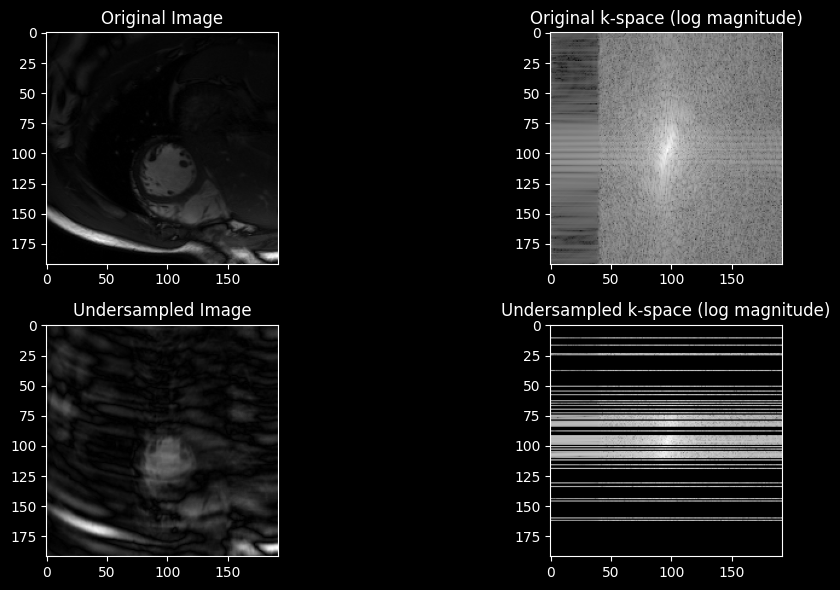

mask_np shape: (1, 2, 192, 192, 18)


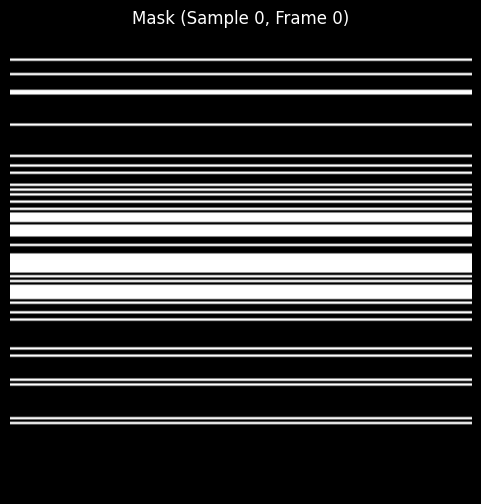

In [26]:

# import argparse
import yaml

# 直接指定配置文件路径（适用于 Jupyter Notebook）
config_path = '/nfs/zzy/code/k_gin_base/config_test.yaml'  # 替换为你的配置文件路径

# 加载配置文件
with open(config_path) as f:
    print(f'Using {config_path} as config file')
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2obj(config)
# config-data: {'train_subjs': '/nfs/zzy/data/k_gin_data/k_cine_multicoil_training.npy', 
# 'train_maps': '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_training.npy', 
# 'val_subjs': '/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy', 
# 'val_maps': '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy', 
# 'mask_root': '/nfs/zzy/code/k_gin_base/masks/VISTA/e_192x18_acs4_R4.mat', 
# 'data_root': '/nfs/zzy/data/k_gin_data', 'mask_pattern': 'VISTA', 'acc_rate': [4], 
# 'dtype': 'complex128', 'training_patch_time': 16, 'only_infer': False}
print('config-data:',config)
# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# 加载数据集
# config = ...  # 这里需要提供您的配置文件
train_ds = CINE2DT(config=config.data, mode='val')
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=1, shuffle=False)

# 获取一个样本
for kspace, coilmaps, sampling_mask in train_loader:
    kspace = kspace.to(device)
    coilmaps = coilmaps.to(device)
    sampling_mask = sampling_mask.to(device)
    break

# 将多线圈数据转换为单线圈数据
ref_kspace, ref_img = multicoil2single(kspace, coilmaps)
# torch.Size([1, 18, 192, 192])
# torch.Size([1, 18, 192, 192])
print('ref_kspace:',ref_kspace.shape)
print('ref_img',ref_img.shape)

# 准备输入数据（欠采样）
acc_rate_value = 4  # 欠采样率
im_undersample, k_undersample, mask, im_groudtruth = prep_input(ref_img, acc_rate_value)
# im_undersample: torch.Size([1, 2, 192, 192, 18])
# k_undersample: torch.Size([1, 2, 192, 192, 18])
# mask: torch.Size([1, 18, 192, 192])
# im_groudtruth: torch.Size([1, 2, 192, 192, 18])
print('im_undersample:',im_undersample.shape)
print('k_undersample:',k_undersample.shape)
print('mask:',mask.shape)
print('im_groudtruth:',im_groudtruth.shape)

# ref_img shape: torch.Size([1, 18, 192, 192])
print(f"ref_img shape: {ref_img.shape}")

ref_img_np = ref_img.cpu().numpy()[0]
print('ref_img_np:',ref_img_np.shape)
ref_kspace_np = ref_kspace.cpu().numpy()[0]
print('ref_kspace:',ref_kspace_np)

# 将下采样后的图像和 k 空间转换为 NumPy 数组
im_undersample_np = im_undersample.cpu().numpy()[0]  # 提取第一个样本，形状为 (2, 192, 192, 18)
k_undersample_np = k_undersample.cpu().numpy()[0]    # 提取第一个样本，形状为 (2, 192, 192, 18)

# 打印形状以调试
print('im_undersample_np shape:', im_undersample_np.shape)  # 输出: (2, 192, 192, 18)
print('k_undersample_np shape:', k_undersample_np.shape)    # 输出: (2, 192, 192, 18)

# 选择第一个通道和第一个时间帧进行可视化
im_undersample_frame = im_undersample_np[0, :, :, 0]  # 形状为 (192, 192)
k_undersample_frame = k_undersample_np[0, :, :, 0]    # 形状为 (192, 192)

# im_undersample: torch.Size([1, 18, 192, 192])
# k_undersample: torch.Size([1, 18, 192, 192])
# mask: torch.Size([1, 18, 192, 192])
# im_groudtruth: torch.Size([1, 18, 192, 192])
# im_undersample = Variable(im_undersample.type(Tensor))
# k_undersample = Variable(k_undersample.type(Tensor))
# mask = Variable(mask.type(Tensor))
# im_groudtruth = Variable(im_groudtruth.type(Tensor))
# print('im_undersample:',im_undersample.shape)
# print('k_undersample:',k_undersample.shape)
# print('mask:',mask.shape)
# print('im_groudtruth:',im_groudtruth.shape)
                
# 可视化原始图像和 k 空间
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(np.abs(ref_img_np[0]), cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Original k-space (log magnitude)')
plt.imshow(np.log(np.abs(ref_kspace_np[0]) + 1e-9), cmap='gray')

# 可视化欠采样后的图像和 k 空间
plt.subplot(2, 2, 3)
plt.title('Undersampled Image')
plt.imshow(np.abs(im_undersample_frame), cmap='gray')

plt.subplot(2, 2, 4)
plt.title('Undersampled k-space (log magnitude)')
# plt.imshow(np.log(np.abs(k_undersample_np[0]) + 1e-9), cmap='gray')
plt.imshow(np.log(np.abs(np.fft.fftshift(k_undersample_frame)) + 1e-9), cmap='gray')


plt.tight_layout()
plt.show()


# # 将 mask 转换为 NumPy 数组
# mask_np = mask.cpu().numpy()[0]  # 提取第一个样本，形状为 (18, 192, 192)
# # 打印形状以调试
# print('mask_np shape:', mask_np.shape)  # 输出: (18, 192, 192)
# # 选择第一个时间帧进行可视化
# mask_frame = mask_np[0]  # 形状为 (192, 192)
# # 可视化掩码
# plt.figure(figsize=(6, 6))
# plt.imshow(np.fft.fftshift(mask_frame), cmap='gray')  # 使用 fftshift 将掩码居中显示
# plt.title('Mask (Frame 0)')
# plt.axis('off')
# plt.show()
# 将 mask 转换为 NumPy 数组
mask_np = mask.cpu().numpy()  # 形状为 (1, 2, 192, 192, 18)
# 打印形状以调试
print('mask_np shape:', mask_np.shape)  # 输出: (1, 2, 192, 192, 18)
# 选择第一个样本和第一个时间帧进行可视化
mask_frame = mask_np[0,0, :, :, 0]  # 形状为 (192, 192)
# 可视化掩码
plt.figure(figsize=(6, 6))
plt.imshow(np.fft.fftshift(mask_frame), cmap='gray')  # 使用 fftshift 将掩码居中显示
plt.title('Mask (Sample 0, Frame 0)')
plt.axis('off')
plt.show()